# Exploratory statistics and summaries of the pQTL data and loci

In [1]:
import numpy
import pandas
import plotnine

%matplotlib inline

/home/dhimmel/anaconda3/envs/hetmech/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Read loci

In [2]:
locus_df = pandas.read_table('snps-to-locus-genes.tsv')
locus_df.head(2)

,snp,locus_gene,locus_entrez_id,distance_to_snp
0,rs651007,ABO,28,3217
1,rs651007,SURF6,6838,50343


In [3]:
## Number of loci (lead SNPs)
len(locus_df)

131465

In [4]:
locus_df.distance_to_snp.max()

999962

In [5]:
snps_per_locus_df = locus_df.groupby(['locus_entrez_id', 'locus_gene']).snp.count().rename('n_snps').reset_index()
snps_per_locus_df.head(2)

,locus_entrez_id,locus_gene,n_snps
0,2,A2M,2
1,3,A2MP1,2


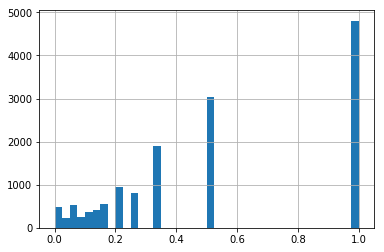

In [6]:
# Under the naive assumption that every gene in a locus is equally likely to be causual, plot the prior probability of causility for genes for each locus
(1 / snps_per_locus_df.n_snps).hist(bins=numpy.arange(0, 1.01, 0.025));

## Plot number of SNPs per locus at various distance cutoffs

In [7]:
bin_edges = numpy.arange(start=0, stop=1_000_001, step=1_000)

def summarize_distance(df):
    """
    An inefficient method for counting the number of SNPs within
    various distances.
    """
    counts, _ = numpy.histogram(df.distance_to_snp, bins=bin_edges)
    return numpy.cumsum(counts)

results = locus_df.groupby('locus_entrez_id').apply(summarize_distance)
n_snps_df = pandas.DataFrame(dict(zip(results.index, results.values)), index=bin_edges[1:])
n_snps_df.tail(2)

,2,3,9,10,12,15,16,20,21,23,...,110384692,110599563,110599588,110806283,110806285,110841583,111082988,111082989,111082992,111089941
999000,2,2,1,1,31,1,1,5,2,21,...,59,116,2,1,3,2,1,1,1,4
1000000,2,2,1,1,31,1,1,5,2,21,...,59,116,2,1,3,2,1,1,1,4


In [8]:
mean_snp_df = n_snps_df.mean(axis='columns').rename('n_snps').reset_index().rename(columns={'index': 'distance'})
mean_snp_df.head(2)

,distance,n_snps
0,1000,0.039407
1,2000,0.059251


In [9]:
quantile_df = n_snps_df.quantile(q=[0.25, 0.5, 0.75], axis='columns')
quantile_df = quantile_df.stack().reset_index()
quantile_df.columns = 'quantile', 'distance', 'n_snps'
quantile_df.tail(2)

,quantile,distance,n_snps
2998,0.75,999000,5.0
2999,0.75,1000000,5.0


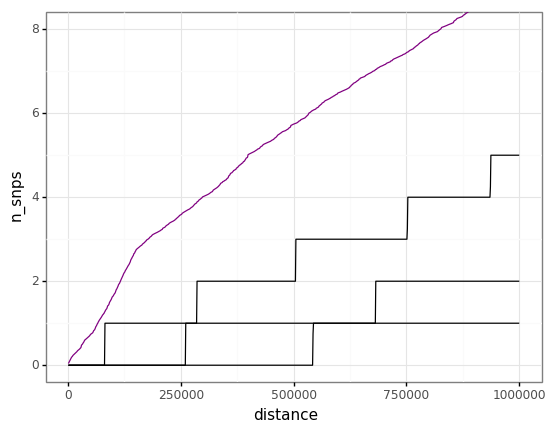

<ggplot: (-9223363284213712808)>

In [10]:
# Plot quartiles and mean number of SNPs within a given distance
(
    plotnine.ggplot(mapping=plotnine.aes(x='distance', y='n_snps', group='quantile'), data=quantile_df) + 
    plotnine.geom_path() +
    plotnine.geom_path(mapping=plotnine.aes(group=False), data=mean_snp_df, color='purple') +
    plotnine.coord_cartesian(ylim=(0, 8)) +
    plotnine.theme_bw()
)

## Read pQTLs

In [11]:
pqtl_df = pandas.read_table('pqtl.tsv')
pqtl_df.head(2)

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source
0,rs651007,SELE,6401,102.728,23300549
1,rs5985,"F13A1,F13B","2165,2162",185.587,23381943


In [12]:
pqtl_locus_df = pqtl_df.merge(locus_df)
pqtl_locus_df.head()

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp
0,rs651007,SELE,6401,102.728,23300549,ABO,28,3217
1,rs651007,SELE,6401,102.728,23300549,SURF6,6838,50343
2,rs651007,SELE,6401,102.728,23300549,MED22,6837,59892
3,rs651007,SELE,6401,102.728,23300549,OBP2B,29989,69181
4,rs651007,SELE,6401,102.728,23300549,RPL7A,6130,69783


In [13]:
pqtl_locus_df.pqtl_gene.nunique()

1607

In [14]:
pqtl_locus_df.locus_gene.nunique()

14219